In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [343]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

from torch import Tensor
from torch import nn

plt.rcParams["image.cmap"] = "copper"  # For immersive Mars vibe

In [400]:
x_train = pd.read_csv("./train_damaged.csv")
x_train.index = x_train.pop("Id")
x_train = x_train.to_numpy().reshape(-1, 50, 50)

y_train = pd.read_csv("./train_undamaged.csv")
y_train.index = y_train.pop("Id")
y_train = y_train.to_numpy().reshape(-1, 100, 100)

x_val = pd.read_csv("./train_damaged.csv")
x_val.index = x_val.pop("Id")
x_val = x_val.to_numpy().reshape(-1, 50, 50)

In [402]:
x_train, x_test = x_train[:160],x_train[160:]
y_train, y_test = y_train[:160],y_train[160:]

In [119]:
def predict(x, batched=False):
    # Very simple prediction: Repeat every pixel once,
    # mapping a 50x50 image to 100x100
    y_pred = np.repeat(x, 2, axis=0 + batched)
    y_pred = np.repeat(y_pred, 2, axis=1 + batched)
    return y_pred

In [121]:
x_mean = x_train.mean(0)

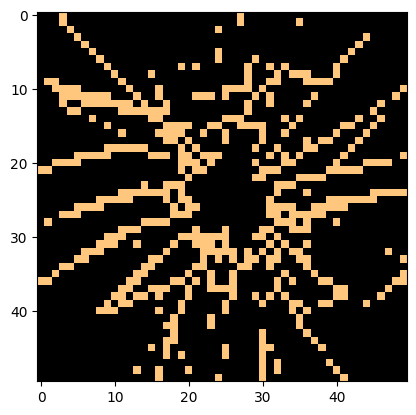

In [122]:
crack_mask = x_mean < 0.2
imshow(crack_mask)

In [134]:
def uncrack(x):
    return x + (x*2.+.5)*crack_mask

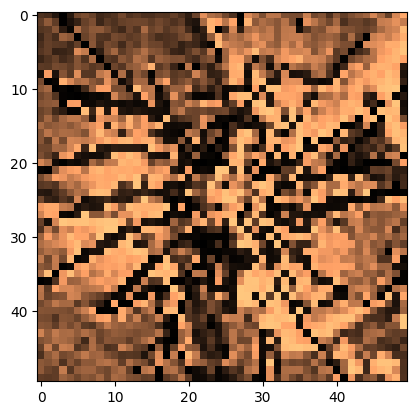

In [135]:
imshow(x_train[1])

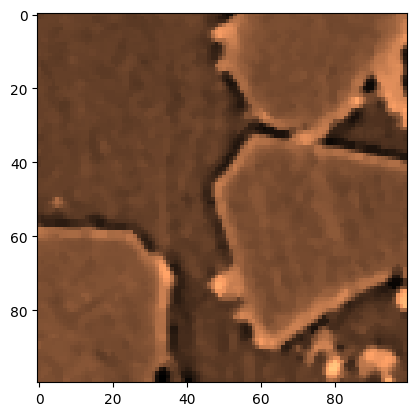

In [136]:
imshow(y_train[1])

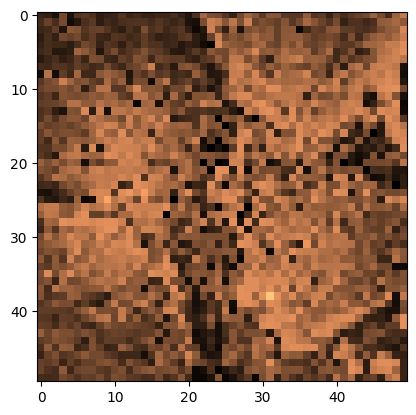

In [137]:
imshow(uncrack(x_train[1]))

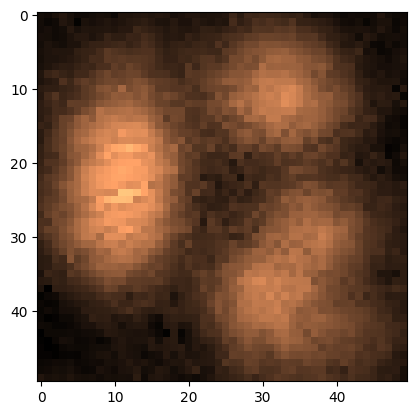

In [141]:
imshow(uncrack(x_mean))

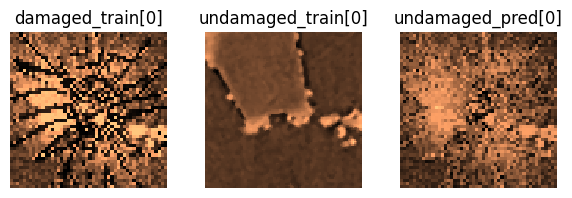

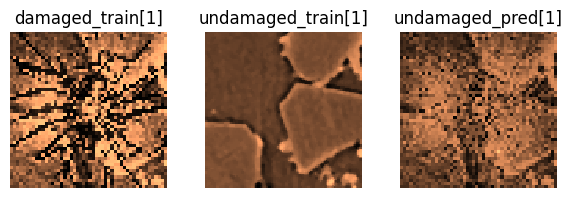

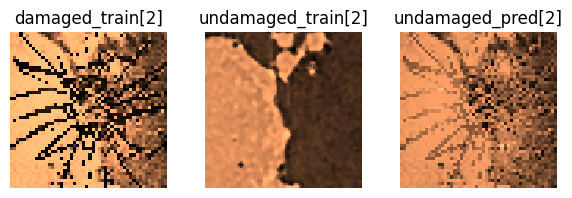

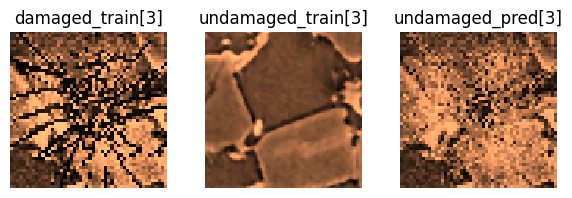

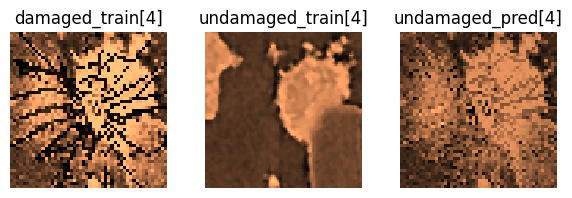

In [140]:
i = 4
for i in range(5):

    plt.figure(figsize=(6, 2))

    plt.subplot(131)
    plt.axis("off")
    plt.imshow(x_train[i], interpolation="none")
    plt.title(f"damaged_train[{i}]")

    plt.subplot(132)
    plt.axis("off")
    plt.imshow(y_train[i], interpolation="none")
    plt.title(f"undamaged_train[{i}]")

    plt.subplot(133)
    plt.axis("off")
    plt.imshow(predict(uncrack(x_train[i])), interpolation="none")
    plt.title(f"undamaged_pred[{i}]")

    plt.tight_layout()

In [169]:
def downsize(a):
    assert a.shape == (100,100)

    xaxis = np.arange(0,100,2).reshape(-1,1)
    yaxis = np.arange(0,100,2)
    return (a[xaxis,yaxis] + 
           a[xaxis+1,yaxis]+
           a[xaxis,yaxis+1]+
           a[xaxis+1,yaxis+1])/4

In [172]:
import torch

In [348]:
lin1.parameters()

<generator object Module.parameters at 0x28b46a2d0>

In [405]:
Loss = torch.nn.MSELoss()
class Model:
    def __init__(self):
        self.l1 = nn.Linear(2500,2500)
        self.parameters = [*self.l1.parameters()]
    
    def __call__(self,x):
        x = Tensor(x).reshape(-1)
        return self.l1(x)

model = Model()
opt = torch.optim.Adam(model.parameters,lr=0.0001)

Loss = nn.MSELoss()
def loss_fn (p,y):
    y = Tensor(downsize(y)).reshape(-1)
    return Loss(y,p)
    
def train_step(x,y):

    pred = model(x)
    loss = loss_fn(pred,y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    global hist
    hist.append(loss.detach().numpy())

loss_hist = []

def epoch (e=0):

    for i,(x,y) in enumerate(zip (x_train,y_train)):
        print (f'\r epoch {e} batch {i} ',end="")
        train_step(x,y)

def train(epochs = 10):
    global hist
    for e in range(epochs):
        hist = []
        epoch(e)
        print (f"\n avg train loss: {sum(hist)/len(hist)}\n")

        loss_hist.append(hist)


train()


 epoch 0 batch 159 
 avg train loss: 0.0442469617119059

 epoch 1 batch 159 
 avg train loss: 0.02766960412845947

 epoch 2 batch 159 
 avg train loss: 0.02185672111809254

 epoch 3 batch 159 
 avg train loss: 0.01764064819435589

 epoch 4 batch 159 
 avg train loss: 0.01440528522944078

 epoch 5 batch 159 
 avg train loss: 0.01187762730405666

 epoch 6 batch 159 
 avg train loss: 0.009884225160931237

 epoch 7 batch 159 
 avg train loss: 0.008306209216243587

 epoch 8 batch 159 
 avg train loss: 0.007058315031463281

 epoch 9 batch 159 
 avg train loss: 0.00607735654048156



hist
hist
hist
hist
hist
hist
hist
hist
hist
hist


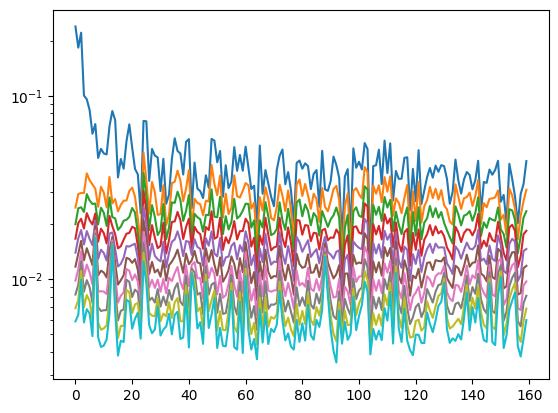

In [408]:
for hist in loss_hist:
    print('hist')
    plt.yscale("log")
    plt.plot(hist)
    # plt.show()

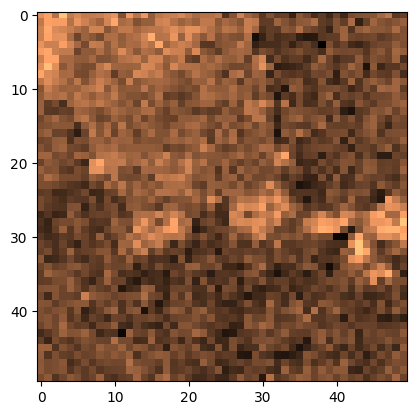

In [415]:
imshow(model(x_train[0]).detach().numpy().reshape((50,50)))

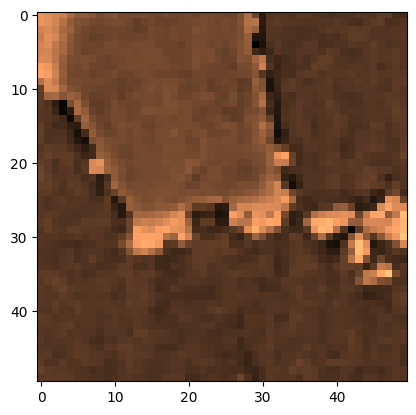

In [417]:
imshow(downsize(y_train[0]))